# Argon as a 2D Van der Waals Fluid
Molecular dynamics simulation

## Packages and Config

In [240]:
include("MolDyn.jl")
using Plots, Plots.PlotMeasures, LaTeXStrings, DataFrames, CSV, Statistics
using StatsBase: autocor

figpath = "fig/"
animpath = "anim/"
framepath = animpath * "frames/"
datapath = "data/"

Plots.default(legend=false, lw=3, fontfamily="Computer Modern",
    titlefontsize=16, labelfontsize=13, tickfontsize=10, legendfontsize=10)

In [52]:
num = 100
sidelen = 30.0

30.0

## Animation (Trajectory)
### Gas Phase

In [ ]:
sim = MolDyn.MolSim(num, 2.0, sidelen, sidelen)
MolDyn.alignleft!(sim)

# initialize animation
anim = Animation(framepath, String[])

# draw first frame
p = scatter(sim.pos[1, :], sim.pos[2, :],
    color=:blue, markerstrokewidth=0, markersize=9,
    title=L"T = 240\mathrm{K},\quad t = 0.0\tau",
    xlabel=L"x/\sigma", ylabel=L"y/\sigma",
    xlim=(0, sidelen), ylim=(0, sidelen), frame=:box,
    grid=false, tickdir=:none,
    size=(600, 600), ratio=:equal, leftmargin=-2mm)
frame(anim, p)

for i in 1:300
    _, temperatures, _ = MolDyn.simulate!(sim, 100, 0.001)
    p = scatter(sim.pos[1, :], sim.pos[2, :],
        color=:blue, markerstrokewidth=0, markersize=9,
        title= "\$T = $(round(120 * temperatures[end], digits=1))\\mathrm{K},"
            * "\\quad t = $(round(0.1 * i, digits=1))\\tau\$",
        xlabel=L"x/\sigma", ylabel=L"y/\sigma",
        xlim=(0, sidelen), ylim=(0, sidelen), frame=:box,
        grid=false, tickdir=:none,
        size=(600, 600), ratio=:equal, leftmargin=-2mm)
    frame(anim, p)
end

gif(anim, animpath * "gas.gif", fps=30)

### Liquid Phase

In [ ]:
sim = MolDyn.MolSim(num, 1.0, sidelen, sidelen)
MolDyn.alignleft!(sim)

# evolve the system to equilibrium
MolDyn.simulate!(sim, 2000, 0.01)
# slowly cool down the system
for i in 1:20
    # reduce temperature by scaling the velocities
    sim.vel *= 0.9
    MolDyn.simulate!(sim, 100, 0.01)
end

# initialize animation
anim = Animation(framepath, String[])

for i in 1:300
    _, temperatures, _ = MolDyn.simulate!(sim, 100, 0.001)
    p = scatter(sim.pos[1, :], sim.pos[2, :],
        color=:blue, markerstrokewidth=0, markersize=9,
        title= "\$T = $(round(120 * temperatures[end], digits=1))\\mathrm{K},"
            * "\\quad t = $(round(0.1 * i, digits=1))\\tau\$",
        xlabel=L"x/\sigma", ylabel=L"y/\sigma",
        xlim=(0, sidelen), ylim=(0, sidelen), frame=:box,
        grid=false, tickdir=:none,
        size=(600, 600), ratio=:equal, leftmargin=-2mm)
    frame(anim, p)
end

gif(anim, animpath * "liquid.gif", fps=30)

### Solid Phase

In [ ]:
sim = MolDyn.MolSim(num, 1.0, sidelen, sidelen)
MolDyn.alignleft!(sim)

# evolve the system to equilibrium
MolDyn.simulate!(sim, 2000, 0.01)
# slowly cool down the system
for i in 1:1000
    # reduce temperature by scaling the velocities
    sim.vel *= 0.8
    MolDyn.simulate!(sim, 100, 0.001)
end

# initialize animation
anim = Animation(framepath, String[])

for i in 1:300
    _, temperatures, _ = MolDyn.simulate!(sim, 100, 0.001)
    p = scatter(sim.pos[1, :], sim.pos[2, :],
        color=:blue, markerstrokewidth=0, markersize=9,
        title= "\$T = $(round(120 * temperatures[end], digits=1))\\mathrm{K},"
            * "\\quad t = $(round(0.1 * i, digits=1))\\tau\$",
        xlabel=L"x/\sigma", ylabel=L"y/\sigma",
        xlim=(0, sidelen), ylim=(0, sidelen), frame=:box,
        grid=false, tickdir=:none,
        size=(600, 600), ratio=:equal, leftmargin=-2mm)
    frame(anim, p)
end

gif(anim, animpath * "solid.gif", fps=30)

### Phase Transition

In [ ]:
sim = MolDyn.MolSim(num, 1.5, sidelen, sidelen)
MolDyn.alignleft!(sim)
# evolve the system to equilibrium
MolDyn.simulate!(sim, 2000, 0.01)

# initialize animation
anim = Animation(framepath, String[])

for i in 1:360
    _, temperatures, _ = MolDyn.simulate!(sim, 100, 0.001)
    p = scatter(sim.pos[1, :], sim.pos[2, :],
        color=:blue, markerstrokewidth=0, markersize=9,
        title= "\$T = $(round(120 * temperatures[end], digits=1))\\mathrm{K},"
            * "\\quad t = $(round(0.1 * i, digits=1))\\tau\$",
        xlabel=L"x/\sigma", ylabel=L"y/\sigma",
        xlim=(0, sidelen), ylim=(0, sidelen), frame=:box,
        grid=false, tickdir=:none,
        size=(600, 600), ratio=:equal, leftmargin=-2mm)
    frame(anim, p)
    # reduce temperature by scaling the velocities
    sim.vel *= 0.99
end

gif(anim, animpath * "phasetransition.gif", fps=30)

## Equlibrium

In [183]:
sim = MolDyn.MolSim(100, 1.0, sidelen, sidelen)
MolDyn.alignleft!(sim)

energies, potentials, temperatures, pressures, leftsidenum = [Array{Float64}(undef, 20001) for _ in 1:5]
potentials[1] = MolDyn.get_potential(sim)
temperatures[1] = MolDyn.get_temperature(sim)
energies[1] = sim.num * temperatures[1] + potentials[1]
pressures[1] = MolDyn.get_pressure(sim)
leftsidenum[1] = 1.0

for i in 2:20001
    potential, temperature, pressure = MolDyn.update!(sim, 0.001)
    potentials[i] = potential
    temperatures[i] = temperature
    energies[i] = sim.num * temperatures[1] + potentials[1]
    pressures[i] = pressure
    leftsidenum[i] = count(<=(sidelen/2), sim.pos[1, :]) / sim.num
end

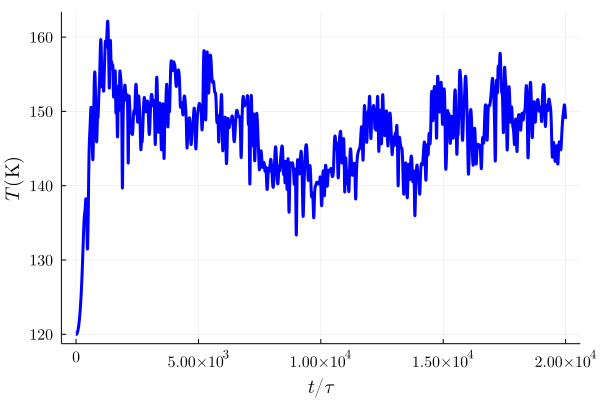

In [184]:
p = plot(120 * temperatures, color=:blue, xlabel=L"t/\tau", ylabel=L"T(\mathrm{K})",
    rightmargin=3mm, bottommargin=2mm)
savefig(p, figpath * "temperature.pdf")
display(p)

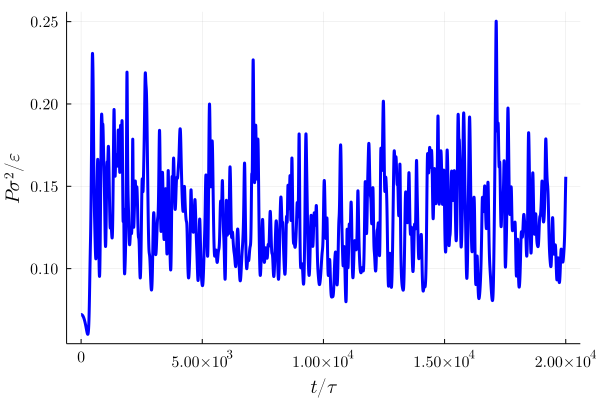

In [185]:
p = plot(pressures, color=:blue, xlabel=L"t/\tau", ylabel=L"P\sigma^2/\epsilon",
    rightmargin=3mm, bottommargin=2mm)
savefig(p, figpath * "pressure.pdf")
display(p)

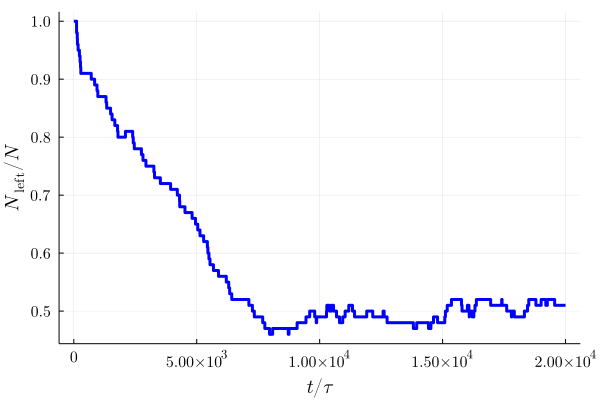

In [186]:
p = plot(leftsidenum, color=:blue, xlabel=L"t/\tau", ylabel=L"N_{\textrm{left}}/N",
    rightmargin=3mm, bottommargin=2mm)
savefig(p, figpath * "leftsidenum.pdf")
display(p)

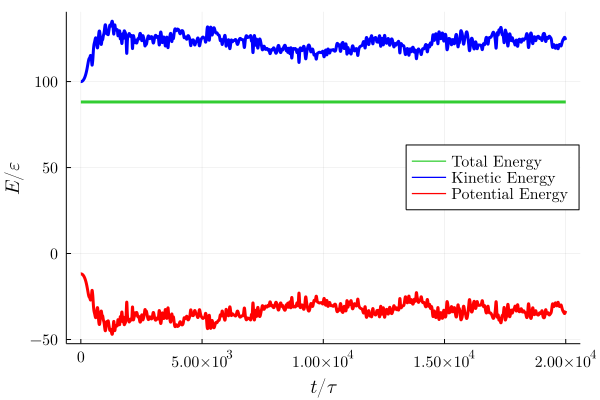

In [187]:
p = plot(energies, color=:limegreen, xlabel=L"t/\tau", ylabel=L"E/\epsilon",
    legend=(0.75, 0.55), label="Total Energy", rightmargin=3mm, bottommargin=2mm)
plot!(sim.num * temperatures, color=:blue, label="Kinetic Energy")
plot!(potentials, color=:red, label="Potential Energy")

savefig(p, figpath * "energy.pdf")
display(p)

## Relaxation Time

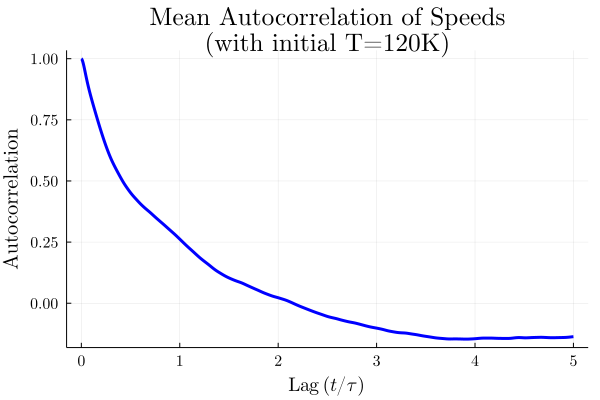

In [226]:
sim = MolDyn.MolSim(100, 1.0, sidelen, sidelen)
MolDyn.alignleft!(sim)
MolDyn.simulate!(sim, 2000, 0.01)

stepcount = 10^4
v = Matrix{Float64}(undef, stepcount, sim.num)
for i in 1:stepcount
    MolDyn.update!(sim, 0.001)
    v[i, :] = @. √(sim.vel[1, :]^2 + sim.vel[2, :]^2)
end

autocorrelation = autocor(v, 1:stepcount÷2)
p = plot(range(0, stepcount / 2 * 0.001, length=stepcount÷2), mean(autocorrelation, dims=2),
    xlabel=L"\textrm{Lag}\ (t/\tau)", ylabel="Autocorrelation",
    title="Mean Autocorrelation of Speeds\n(with initial T=120K)",
    color=:blue, bottommargin=2mm, leftmargin=2mm)
savefig(p, figpath * "autocor.pdf")
display(p)

In [251]:
sim = MolDyn.MolSim(100, 1.0, sidelen, sidelen)
MolDyn.alignleft!(sim)
MolDyn.simulate!(sim, 2000, 0.01)
120 * MolDyn.get_temperature(sim)

140.36638771307378

In [229]:
# finding the correlation length with semi-log simple linear regression
thresh = 1000
lags = collect(range(0, thresh * 0.001, length=thresh))
autocorlog = log.(mean(autocorrelation[1:thresh, :], dims=2))

negative_inverse_ξ, coeff = hcat(lags, ones(thresh)) \ autocorlog
negative_inverse_ξ_error = √(sum(x->x^2, autocorlog - negative_inverse_ξ * lags .- coeff)
    / (thresh - 2) / sum(x->x^2, lags .- mean(lags)))

ξ = - 1 / negative_inverse_ξ
ξerror = negative_inverse_ξ_error / ξ^2
print(ξ, ' ', ξerror)

0.7823219096073124 0.008167365116099369

## Van Der Waals Equation

In [252]:
# load data collected with the VanDerWaals.jl module
df = DataFrame(CSV.File(datapath * "vanderwaals-N$num-L$sidelen.csv"))
meanT = df."temperature mean"
σT = df."temperature std"
meanP = df."pressure mean"
σP = df."pressure std"

41-element Vector{Float64}:
 0.025059613366117946
 0.02984395698854373
 0.027801043713211154
 0.029543758931862698
 0.02950056804586818
 0.03031759489434908
 0.027939651049980276
 0.0331195008777892
 0.03310609981392959
 0.03167095852940619
 ⋮
 0.04535900516480407
 0.0466309118043707
 0.04622080364779174
 0.046984005654095426
 0.043173942875357786
 0.04643898012297027
 0.047159657965801204
 0.04577997061466517
 0.04730189374383

In [257]:
slope, intercept = hcat(meanT, ones(length(meanT))) \ meanP
slope_error = √(sum(x->x^2, meanP - slope * meanT .- intercept)
    / (length(meanT) - 2) / sum(x->x^2, meanT .- mean(meanT)))
intercept_error = slope_error * √(mean(x->x^2, meanT))

println(slope, ' ', slope_error)
println(intercept, ' ', intercept_error)

0.13101566076175947 0.00042434178772131646
-0.027812989033242967 0.000986078584182012


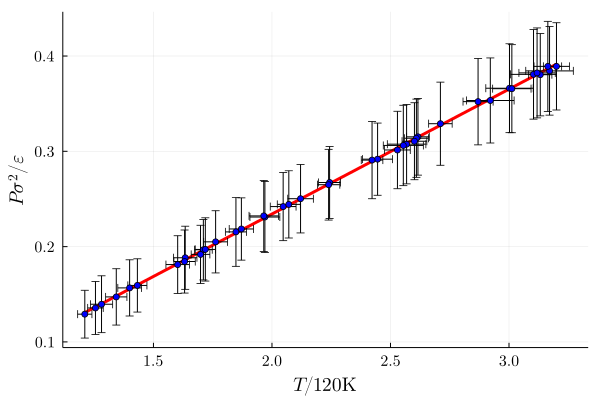

In [266]:
p = plot(x -> slope * x + intercept, minimum(meanT), maximum(meanT), color=:red,
    xlabel=L"T/120\mathrm{K}", ylabel=L"P\sigma^2/\epsilon",
    bottommargin=2mm, leftmargin=2mm)
scatter!(p, meanT, meanP, xerr=σT, yerr=σP, ms=4, color=:blue)

savefig(figpath * "vanderwaals.pdf")
display(p)